# Import Dependencies

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data into pandas dataframe
data = pd.read_csv("Combined Data.csv")
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
# check info to know the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


# Data cleaning

In [4]:
# check for null value
data.isnull().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

In [5]:
# remove null values
data.dropna(subset=['statement'],inplace=True)

In [6]:
# remove unwanted columns
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [7]:
data.head() # check the first 5 rows

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [8]:
# check for duplicates
data.duplicated().sum()


1588

In [9]:
# drop duplicates 
data.drop_duplicates(inplace=True)

In [10]:
# check for the unique values in the status
data['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [11]:
# convert statement with Dtype object to string
data['statement'] = data['statement'].astype('string')

# convert the categorical column to category
data['status'] = pd.Categorical(data['status'])


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51093 entries, 0 to 52840
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   statement  51093 non-null  string  
 1   status     51093 non-null  category
dtypes: category(1), string(1)
memory usage: 848.6 KB


# Exploratory Data Analysis

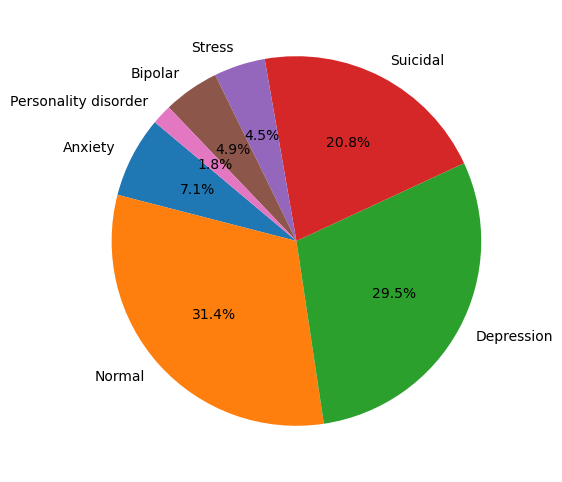

In [14]:
# find the total percentage of statements that fall in the different state category
cat_list = ['Anxiety','Normal','Depression','Suicidal','Stress','Bipolar','Personality disorder']
plt.figure(figsize=(6,6))
total = [data[(data['status']==i)].value_counts().sum() for i in cat_list]
total = list(map(int, total))
plt.pie(total,labels=cat_list, autopct='%1.1f%%', startangle=140)
plt.show()

In [15]:
# total number of each catgeory 
for i in cat_list:
    total = data[(data['status']==i)].shape[0]
    print(f'Category {i}, Total: {total}')

Category Anxiety, Total: 3623
Category Normal, Total: 16040
Category Depression, Total: 15094
Category Suicidal, Total: 10644
Category Stress, Total: 2296
Category Bipolar, Total: 2501
Category Personality disorder, Total: 895


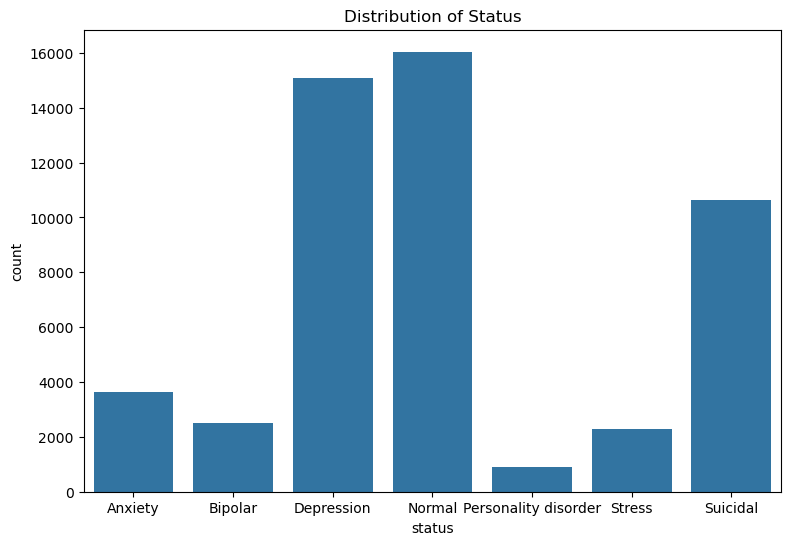

In [16]:
plt.figure(figsize=(9,6))
sns.countplot(data,x='status')
plt.title('Distribution of Status')
plt.show()

the plot shows that most mental state are normal

In [36]:
# find the text lenght
text_lenght_data = data.copy()
text_lenght_data['text lenght'] = text_lenght_data['statement'].apply(lambda x: len(str(x).split()))
text_lenght_data['text lenght']=text_lenght_data['text lenght'].astype(float)
text_lenght_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51093 entries, 0 to 52840
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   statement    51093 non-null  string  
 1   status       51093 non-null  category
 2   text lenght  51093 non-null  float64 
dtypes: category(1), float64(1), string(1)
memory usage: 1.2 MB


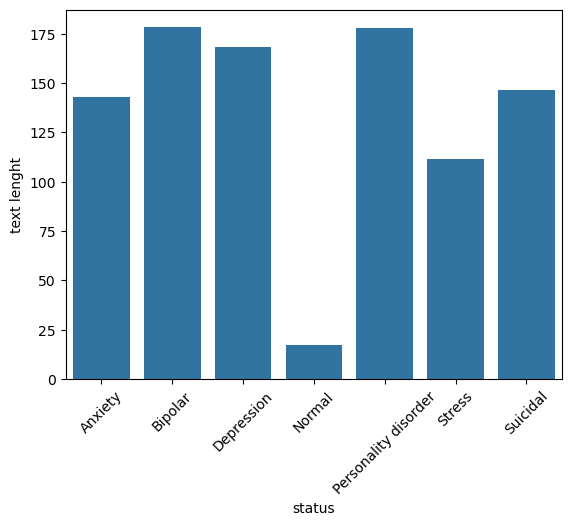

In [54]:
average_lengths = [text_lenght_data.groupby('status')['text lenght'].mean()]

lenght=pd.DataFrame(average_lengths,index=['text lenght']).T

sns.barplot(lenght,x='status',y='text lenght')
plt.xticks(rotation=45)
plt.show()

### people with bipolar mental state talk have lenghty text, while those with a normal mental have short text.

In [100]:
# Group by 'status' and calculate the mean of 'text length'
status_with_max_length = text_lenght_data.groupby('status')['text lenght'].mean().idxmax()

print(f"The status with the highest average text length is: {status_with_max_length}")


The status with the highest average text length is: Bipolar


In [149]:
#data.dropna(subset=['statement'],inplace=True)

remove unwanted characters

In [56]:
# remove unwanted characters
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    #text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text

In [58]:
# apply the process text function
data['statement'] = data['statement'].apply(lambda x:preprocess_text(x))

In [59]:
data.head()

,statement,status
0,oh my gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,all wrong back off dear forward doubt stay in ...,Anxiety
3,ive shifted my focus to something else but im ...,Anxiety
4,im restless and restless its been a month now ...,Anxiety


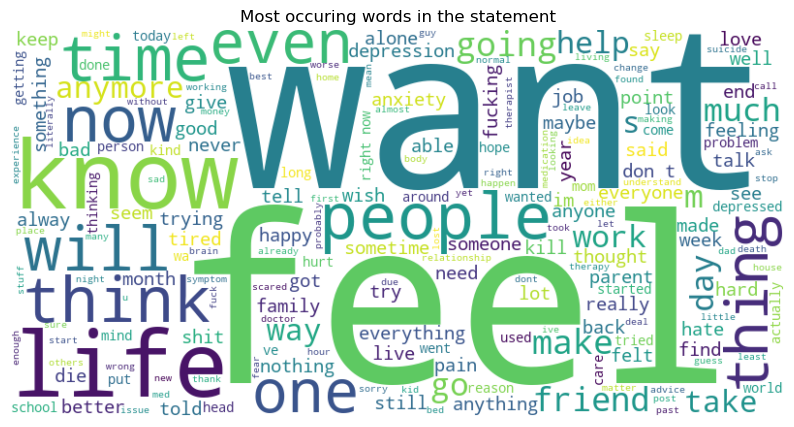

In [60]:
# visualize the most occuring word in statement
text = ' '.join(data['statement'].astype('str'))
plt.figure(figsize=(10,9))
wc = WordCloud(width=800,height=400,background_color='white').generate(text)
plt.title('Most occuring words in the statement')
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

In [61]:
stop_words = set(stopwords.words('english'))
#check for stop words
def check_forStopWords(text):
    tokens = word_tokenize(text)
    words = [word for word in stop_words if word in stop_words]
    return words

In [62]:
data['statement'].apply(lambda x: check_forStopWords(x))

0        [about, a, it, off, because, yourselves, then,...
1        [about, a, it, off, because, yourselves, then,...
2        [about, a, it, off, because, yourselves, then,...
3        [about, a, it, off, because, yourselves, then,...
4        [about, a, it, off, because, yourselves, then,...
                               ...                        
52835    [about, a, it, off, because, yourselves, then,...
52836    [about, a, it, off, because, yourselves, then,...
52837    [about, a, it, off, because, yourselves, then,...
52839    [about, a, it, off, because, yourselves, then,...
52840    [about, a, it, off, because, yourselves, then,...
Name: statement, Length: 51093, dtype: object

There are stop words in the statement column

In [63]:
# remove stop words
def remove_stopWords(text):
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word.lower() not in stop_words]  # Remove stop words
    return ' '.join(tokens) 

In [64]:
data['statement'] = data['statement'].apply(lambda x:remove_stopWords(x))
data.head()

,statement,status
0,oh gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,wrong back dear forward doubt stay restless re...,Anxiety
3,ive shifted focus something else im still worried,Anxiety
4,im restless restless month boy mean,Anxiety


# Modelling
1. Logistic regression
2. Decision Tree classifier
3. Random Forest Classifier

In [65]:
# split dataset into train and test
X=data['statement']
y=data['status']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [66]:
# convert the texts into vectors 
tfidf = TfidfVectorizer(max_features=5000)
X_train_tv = tfidf.fit_transform(X_train)
X_test_tv = tfidf.transform(X_test)

# Logistic Regression

In [67]:
lgr = LogisticRegression()
lgr.fit(X_train_tv,y_train)


LogisticRegression()

In [69]:
y_pred_lgr = lgr.predict(X_test_tv)

In [71]:
accuracy = accuracy_score(y_test,y_pred_lgr)

In [72]:
round(accuracy,1)*100

80.0

In [74]:
# confusion matrix

cfm = confusion_matrix(y_test,y_pred_lgr)

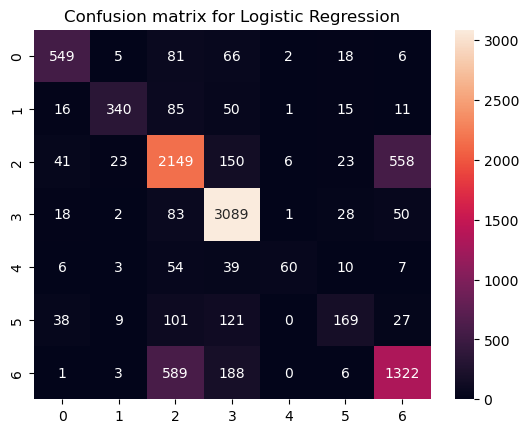

In [75]:
sns.heatmap(cfm, annot=True,fmt='d')
plt.title('Confusion matrix for Logistic Regression')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [76]:
dt = DecisionTreeClassifier()
dt.fit(X_train_tv,y_train)

DecisionTreeClassifier()

In [77]:
y_pred_dt = dt.predict(X_test_tv)

In [78]:
accuaracy_dt = accuracy_score(y_pred_dt,y_test)
round(accuaracy_dt)*100

100

In [80]:
cfm_dt = confusion_matrix(y_pred_dt,y_test)

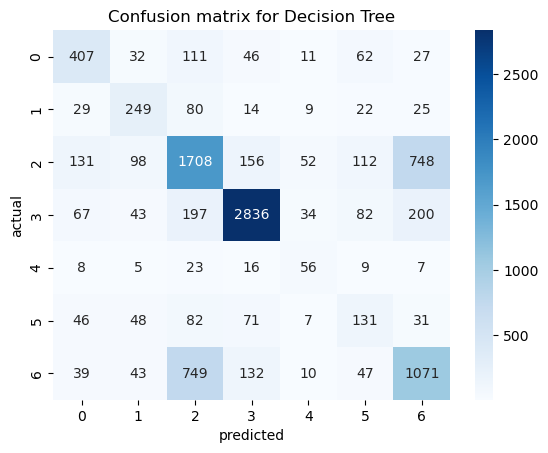

In [81]:
sns.heatmap(cfm_dt,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion matrix for Decision Tree')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [82]:
rfc = RandomForestClassifier()
rfc.fit(X_train_tv,y_train)

RandomForestClassifier()

In [83]:
y_pred_rfc = rfc.predict(X_test_tv)

In [84]:
accuaracy_rfc = accuracy_score(y_pred_rfc,y_test)
round(accuaracy_dt)*100

100

In [85]:
cfm_rfc = confusion_matrix(y_pred_rfc,y_test)

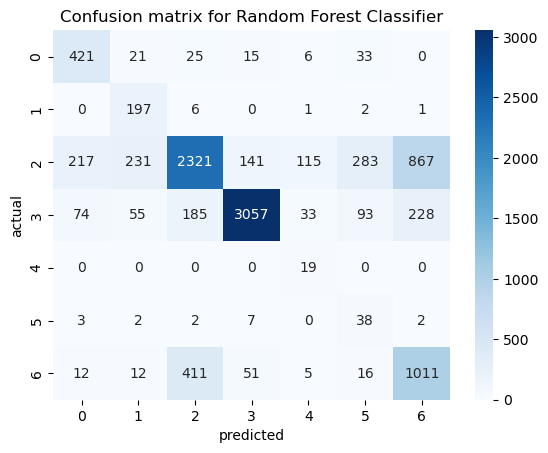

In [86]:
sns.heatmap(cfm_rfc,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion matrix for Random Forest Classifier')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

In [89]:
# classification report for Logistic regression
report_lgr = classification_report(y_test,y_pred_lgr,output_dict=True)
report_df_lgr = pd.DataFrame(report_lgr).transpose()
report_df_lgr


,precision,recall,f1-score,support
Anxiety,0.820628,0.755158,0.786533,727.000000
Bipolar,0.883117,0.656371,0.753045,518.000000
Depression,0.683959,0.728475,0.705515,2950.000000
Normal,0.834188,0.944360,0.885862,3271.000000
Personality disorder,0.857143,0.335196,0.481928,179.000000
Stress,0.628253,0.363441,0.460490,465.000000
Suicidal,0.667340,0.626837,0.646455,2109.000000
accuracy,0.751346,0.751346,0.751346,0.751346
macro avg,0.767804,0.629977,0.674261,10219.000000
weighted avg,0.748933,0.751346,0.744161,10219.000000


In [90]:
# classification report for Decision tree
report_dt = classification_report(y_test,y_pred_dt,output_dict=True)
report_df_dt = pd.DataFrame(report_dt).transpose()
report_df_dt

,precision,recall,f1-score,support
Anxiety,0.584770,0.559835,0.572031,727.00000
Bipolar,0.581776,0.480695,0.526427,518.00000
Depression,0.568386,0.578983,0.573636,2950.00000
Normal,0.819890,0.867013,0.842793,3271.00000
Personality disorder,0.451613,0.312849,0.369637,179.00000
Stress,0.314904,0.281720,0.297389,465.00000
Suicidal,0.512195,0.507824,0.510000,2109.00000
accuracy,0.631960,0.631960,0.631960,0.63196
macro avg,0.547648,0.512703,0.527416,10219.00000
weighted avg,0.625558,0.631960,0.628007,10219.00000


In [91]:
# classification report for Random forest classification
report_rfc = classification_report(y_test,y_pred_rfc,output_dict=True)
report_df_rfc = pd.DataFrame(report_rfc).transpose()
report_df_rfc

,precision,recall,f1-score,support
Anxiety,0.808061,0.579092,0.674679,727.000000
Bipolar,0.951691,0.380309,0.543448,518.000000
Depression,0.555928,0.786780,0.651509,2950.000000
Normal,0.820671,0.934577,0.873928,3271.000000
Personality disorder,1.000000,0.106145,0.191919,179.000000
Stress,0.703704,0.081720,0.146435,465.000000
Suicidal,0.666008,0.479374,0.557486,2109.000000
accuracy,0.691261,0.691261,0.691261,0.691261
macro avg,0.786580,0.478285,0.519915,10219.000000
weighted avg,0.715889,0.691261,0.668436,10219.000000


In [92]:
# metrics = ['precision','recall','f1-score']

# #create a dataframe for the selected matrix

# plot_df = report_df.loc[report_df.index != 'accuracy',metrics]

# plt.figure(figsize=(10,9))
# sns.barplot(plot_df, palette='viridis')
# plt.title('Perfromance Metrics')
# plt.xlabel('Metrics')
# plt.ylabel('Score')
# plt.xticks(rotation=45)
# plt.show()

In [96]:
# make Prediction

text = ["I am feel dark on the inside"]
# vectorize the new text
def predict(model):
    # vectorize the new text
    new_text = tfidf.transform(text)
    prediction = model.predict(new_text)
    return prediction

In [97]:
# logistic Regression
predict(lgr)

array(['Depression'], dtype=object)

In [98]:
# Decision Tree
predict(dt)

array(['Normal'], dtype=object)

In [99]:
# random forest Classifier
predict(rfc)

array(['Normal'], dtype=object)